In [1]:
%matplotlib inline
# You need to have caffe installed with python support, and the BVLC reference models
# downloadad.  Please refer to the caffe website/codebase for instructions.
import caffe
import progressbar
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as pmg

In [2]:
caffe.set_mode_gpu()
MNmodel = '../deepmnist/model/mnist3/model.net'
MNweight = '../deepmnist/model/mnist3/para_iter_5000.caffemodel'
#MNmodel = './mnist_test.prototxt'
#MNweight = './dst.caffemodel'
# NOTE: you must change deploy.prototxt to include "force_backward: true"
net = caffe.Net(MNmodel, MNweight, 1)

In [3]:
def transformCurrent(current, means):
    image = (current + means).transpose(1,2,0)[:,:,0]
    image = image - image.min()
    image = image/image.max()
    return image

In [6]:
def obj_L2(dst):
    dst.diff[:] = dst.data

def makeStep(net, end, jitter=32,step_size=1.5, helper=obj_L2):
    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    #net.forward(end=end)
    net.forward()
    helper(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
    
def oneLoop(net, img, IT=10, rate_obj=1000, rate_smooth=0, means=0.3, a=1, b=0.5, layer='ip2'):
    current = img - means
    net.blobs['data'].data[...] = img
    
    for i in xrange(IT):
        makeStep(net, end=layer)
    
    plt.imshow(net.blobs['data'].data[0][0], cmap='gray')
    plt.show()

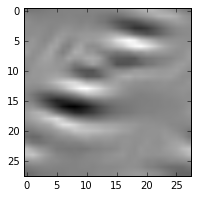

In [7]:
#img = pmg.imread('pic/0_7.png').reshape((1,28,28))
img = np.random.rand(1,28,28)
plt.imshow(img[0], cmap='gray')

plt.rcParams['figure.figsize'] = (3,3)
oneLoop(net=net, img=img, layer='ip2', IT=1000)

In [8]:
net.forward(blobs=['ip2'])

{'ip2': array([[ -4.08477617e+04,  -2.06506074e+04,  -1.17284355e+04,
           5.43926602e+04,  -1.86791719e+04,   6.90853438e+04,
          -7.59835938e+04,  -6.32767067e+01,  -1.85302234e+03,
           6.74761250e+04]], dtype=float32),
 'loss': array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)}